# 

In [1]:
import sys
import datetime
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from iterstrat.ml_stratifiers import (
    MultilabelStratifiedKFold
)
from sklearn.metrics import log_loss
from sklearn.utils.class_weight import compute_class_weight

# import PyTorch Modules
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from torch.utils.data import (
    Subset
)

# import PyTorch Modules for ComputerVision.
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms
import torchvision.transforms.v2.functional as F
from torchvision.io import read_image
from torchvision.models import resnet18, efficientnet_v2_s
from torcheval.metrics import MulticlassAUROC

sys.path.append("../src/")
plt.rcParams["savefig.bbox"] = 'tight'
plt.ion()   # interactive mode
cudnn.benchmark = True


c:\Users\G4WAND\.venv\data-analysis310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# my modules for RSNA2023.
from dataset_handler import AbdominalTraumaDataset, make_datalodaers
from model import MultiAbdominalTraumaClassifier
from metric import score, add_sample_weights, make_submission_file


In [3]:
# Train Parameters #
start_time = datetime.datetime.today().strftime("%Y%m%d%H%M")
save_dir = Path(rf"D:\RSNA2023\data\out\models\baseline\{start_time}")
save_dir.mkdir(parents=True, exist_ok=True)

n_split = 4
num_epoch = 15
learning_rate = 5e-5
step_size = 10
gamma = 0.1
batch_size = 32
random_state = 0
stride = 4

criterions_weights = {
    "bowel_injury": 1,
    "extravasation_injury": 3,
    "kidney_injury": 3,
    "liver_injury": 3,
    "spleen_injury": 3,
    "any_injury": 0.5,
    "incomplete_organ": 0.5
}

optimizer = "AdamW"
backbone = efficientnet_v2_s
b_weights = "IMAGENET1K_V1"

train_transform = nn.Sequential(
    transforms.Resize((224, 224), antialias=True),
    transforms.RandomAdjustSharpness(1.80, p=0.5),
    transforms.RandomErasing(p=0.5, scale=(0.001, 0.005), ratio=(1, 1)),
    transforms.ConvertDtype(),
    transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
)

valid_transform = nn.Sequential(
    transforms.Resize((224, 224), antialias=True),
    transforms.ConvertDtype(),
    transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# ---------------- #


In [4]:
# utilities.
def torch_fix_seed(seed:int=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms = True


torch_fix_seed(random_state)


In [5]:
train_image_root_dir = Path(
    r"D:\RSNA2023\data\train_images"
)

patient_info = pd.read_csv(
    r"D:\RSNA2023\data\train.csv"
)
patient_series = pd.read_csv(
    r"D:\RSNA2023\data\train_series_meta.csv"
)


In [6]:
# calc class weights..
data = patient_series.merge(patient_info)
data["kidney_injury"] = data["kidney_low"] + (data["kidney_high"] * 2)
data["liver_injury"] = data["liver_low"] + (data["liver_high"] * 2)
data["spleen_injury"] = data["spleen_low"] + (data["spleen_high"] * 2)

target_labels = [
    "bowel_injury",
    "extravasation_injury",
    "kidney_injury",
    "liver_injury",
    "spleen_injury",
    "any_injury",
    "incomplete_organ",
]

class_weights = {}
for label in target_labels:
    class_weights[label] = torch.from_numpy(
        compute_class_weight(
            class_weight="balanced",
            classes=np.sort(data.loc[:, label].unique()),
            y=data.loc[:, label].values)
        .astype(np.float32)
    )
    print(
        f"{label} weights: " +
        ", ".join(str(_.item()) for _ in class_weights[label])
    )


bowel_injury weights: 0.5112871527671814, 22.649038314819336
extravasation_injury weights: 0.534005880355835, 7.851666450500488
kidney_injury weights: 0.3547974228858948, 8.922348022460938, 14.40672779083252
liver_injury weights: 0.3707113564014435, 4.089409828186035, 17.256410598754883
spleen_injury weights: 0.3769403100013733, 4.969409465789795, 6.857350826263428
any_injury weights: 0.6881390810012817, 1.82880437374115
incomplete_organ weights: 0.5355843305587769, 7.525558948516846


In [7]:
# Make dataset for RSNA2023 AbdominalTrauma.
dataset = AbdominalTraumaDataset(
    patient_info,
    patient_series,
    train_image_root_dir,
    img_extension=".png",
    has_pseudo3D_img=True,
    stride=stride
)

# dataset split by multilabel stratified split.
data_spliter = MultilabelStratifiedKFold(
    n_splits=n_split,
    shuffle=True,
    random_state=random_state,
)


In [8]:
def calc_multiclasses_roc(y_pred, y_true, classes, show_score):
    j, scores = 0, []

    for i, (cls, num) in enumerate(classes.items()):
        metric = MulticlassAUROC(num_classes=num)
        metric.update(y_pred[:, j:num+j], y_true[:, i])
        scores.append(metric.compute().item())
        j += num
        if show_score:
            print(f"{cls}' ROC: {scores[-1]}")

    return scores


# 📚 Train...

[Epoch: 15/15, Phase: valid]: 100%|██████████| 37/37 [00:06<00:00,  6.10it/s]


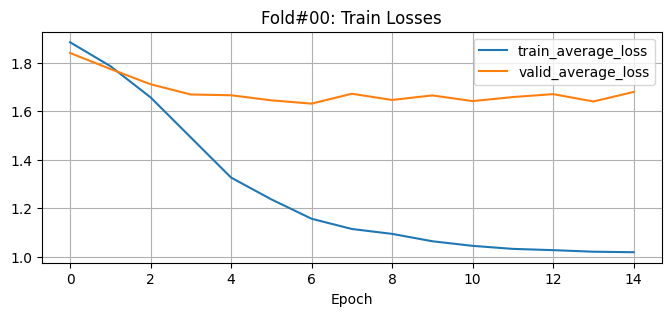

fold#00's best epoch: E006


100%|██████████| 1177/1177 [00:23<00:00, 49.44it/s]
C:\Users\G4WAND\AppData\Local\Temp\ipykernel_12536\2310926786.py:109: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  torch.tensor(pred_test_series),


bowel_injury' ROC: 0.8652008175849915
extravasation_injury' ROC: 0.7254143953323364
kidney_injury' ROC: 0.737288773059845
liver_injury' ROC: 0.7666881680488586
spleen_injury' ROC: 0.721306324005127


[Epoch: 15/15, Phase: valid]: 100%|██████████| 37/37 [00:07<00:00,  4.96it/s]


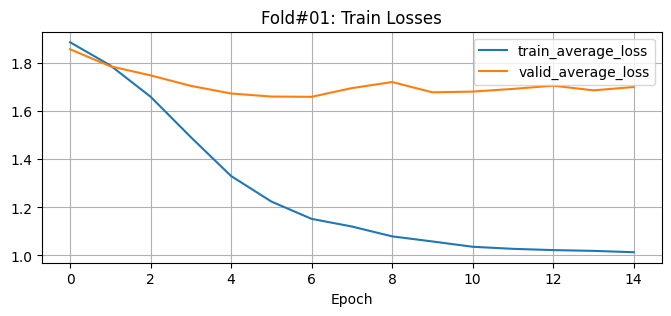

fold#01's best epoch: E006


100%|██████████| 1178/1178 [00:29<00:00, 40.51it/s]


bowel_injury' ROC: 0.7699319124221802
extravasation_injury' ROC: 0.7710849046707153
kidney_injury' ROC: 0.720015287399292
liver_injury' ROC: 0.7068395018577576
spleen_injury' ROC: 0.7341134548187256


[Epoch: 15/15, Phase: valid]: 100%|██████████| 37/37 [00:06<00:00,  5.97it/s]


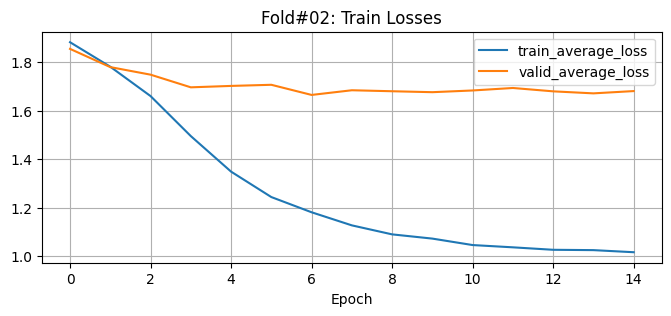

fold#02's best epoch: E006


100%|██████████| 1178/1178 [00:34<00:00, 34.05it/s]


bowel_injury' ROC: 0.8023838400840759
extravasation_injury' ROC: 0.6444605588912964
kidney_injury' ROC: 0.7342098355293274
liver_injury' ROC: 0.7664248943328857
spleen_injury' ROC: 0.727748692035675


[Epoch: 15/15, Phase: valid]: 100%|██████████| 37/37 [00:06<00:00,  5.91it/s]


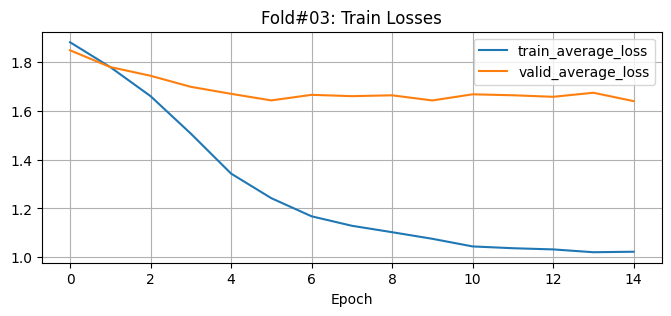

fold#03's best epoch: E014


100%|██████████| 1178/1178 [00:24<00:00, 48.11it/s]

bowel_injury' ROC: 0.8842147588729858
extravasation_injury' ROC: 0.7065820693969727
kidney_injury' ROC: 0.6828307509422302
liver_injury' ROC: 0.7779876589775085
spleen_injury' ROC: 0.6966074109077454


In [9]:
scores, rocs = [], []

for k, (train_indices, valid_indices) in enumerate(data_spliter.split(dataset.labels, dataset.labels)):
    save_sub_dir = save_dir / f"fold#{k:02}"
    save_sub_dir.mkdir(parents=True, exist_ok=True)

    # ----- Train ----- #
    model = MultiAbdominalTraumaClassifier(
        backbone=backbone(weights=b_weights)
    )
    criterions = {
        classname: nn.CrossEntropyLoss(weight=weights.to(device))
        for classname, weights in class_weights.items()
    }

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer,
        step_size=step_size,
        gamma=gamma
    )

    train_dataset = Subset(dataset, train_indices)
    train_dataset.dataset.transform = train_transform
    valid_dataset = Subset(dataset, valid_indices)
    valid_dataset.dataset.transform = valid_transform

    dataloaders = make_datalodaers(
        train_dataset,
        valid_dataset,
        batch_size=batch_size
    )

    history = model.fit(
        dataloaders,
        criterions,
        optimizer,
        exp_lr_scheduler,
        num_epoch,
        save_dir=save_sub_dir,
        criterions_weight=criterions_weights
    )

    train_history = pd.DataFrame(history).T
    train_history.to_csv(save_sub_dir / "history.csv")

    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    ax.set_title(f"Fold#{k:02}: Train Losses")
    ax.set_xlabel("Epoch")
    train_history.loc[:, ["train_average_loss",
                        "valid_average_loss"]].plot(ax=ax)
    ax.grid()

    plt.close()
    display(fig)

    # ----- Scoring with Validation Data -----#
    weighted_cols = [
        "valid_extravasation_injury",
        "valid_kidney_injury",
        "valid_liver_injury",
        "valid_spleen_injury"
    ]

    train_history[weighted_cols] = train_history[weighted_cols] * 3
    best_epoch = train_history.loc[:, [
        "valid_bowel_injury",
        "valid_extravasation_injury",
        "valid_kidney_injury",
        "valid_liver_injury",
        "valid_spleen_injury",
    ]
    ].mean(axis=1).idxmin()

    model.load_model_state(save_sub_dir / f"E{best_epoch:03}.pt", device)
    print(f"fold#{k:02}'s best epoch: E{best_epoch:03}")

    test_patient_series = patient_series.copy().iloc[
        valid_indices, :].reset_index(drop=True)

    test_patient_info = patient_info.copy().set_index("patient_id").loc[
        test_patient_series.patient_id.unique(), :
    ].reset_index()

    test_dataset = AbdominalTraumaDataset(
        test_patient_info,
        test_patient_series,
        train_image_root_dir,
        img_extension=".png",
        transform=nn.Sequential(
            transforms.Resize((224, 224), antialias=True),
            transforms.ConvertDtype(),
            transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
        ),
        has_pseudo3D_img=True,
        stride=stride
    )

    pred_test_series = model.predict(test_dataset)
    y_pred = make_submission_file(
        pred_test_series, test_patient_series.reset_index(drop=True)
    )
    y_true = add_sample_weights(test_patient_info)

    scores.append(score(y_true.copy(), y_pred.copy(), "patient_id"))
    rocs.append(
        calc_multiclasses_roc(
            torch.tensor(pred_test_series),
            test_dataset.labels,
            {
                "bowel_injury": 2,
                "extravasation_injury": 2,
                "kidney_injury": 3,
                "liver_injury": 3,
                "spleen_injury": 3,
            },
            True
        )
    )
    del model


In [10]:
scores = pd.DataFrame(
    scores,
    columns=["bowel", "extravasation", "kidney", "liver", "spleen", "any"]
)
scores["Average"] = scores.mean(axis=1)
scores.loc["CV-Average"] = scores.mean(axis=0)
display(scores)
scores.to_csv(save_dir / "scores.csv")


,bowel,extravasation,kidney,liver,spleen,any,Average
0,0.214535,0.718121,0.594566,0.930191,1.058933,0.766511,0.713810
1,0.259720,0.629265,0.574910,0.909998,1.126010,0.666579,0.694413
2,0.235553,0.770140,0.550304,0.815959,1.061868,0.681101,0.685821
3,0.139537,0.779168,0.543769,0.680744,0.952740,0.949793,0.674292
CV-Average,0.212336,0.724173,0.565887,0.834223,1.049888,0.765996,0.692084


In [11]:
rocs = pd.DataFrame(
    rocs,
    columns=[
        "bowel_injury",
        "extravasation_injury",
        "kidney_injury",
        "liver_injury",
        "spleen_injury"
    ]
)
display(rocs)
rocs.to_csv(save_dir / "AUROC.csv")


,bowel_injury,extravasation_injury,kidney_injury,liver_injury,spleen_injury
0,0.865201,0.725414,0.737289,0.766688,0.721306
1,0.769932,0.771085,0.720015,0.706840,0.734113
2,0.802384,0.644461,0.734210,0.766425,0.727749
3,0.884215,0.706582,0.682831,0.777988,0.696607
